In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import time
import os

from utils import *
from encoder import Encoder
from decoder import DecodeNext, Decoder

%load_ext autoreload
%autoreload 2

### Data & Model Parameters

In [3]:
smiles = fetch_smiles_gdb13('./data/gdb13/')[0]

In [4]:
params = make_params(smiles=smiles, to_file='gdb13_params.json')
#params = make_params(from_file='gdb13_params.json')

In [5]:
total_n = 10000
train_n = 7500
test_n = total_n - train_n

one_hots = to_one_hot(smiles[:total_n], params)

train_dataloader = DataLoader(one_hots[:train_n], batch_size=50, shuffle=True)
test_dataloader = DataLoader(one_hots[train_n:], batch_size=50, shuffle=True)

print(f'total_n = {total_n}')
print(f'train_n = {train_n}')
print(f'test_n = {test_n}')

total_n = 10000
train_n = 7500
test_n = 2500


### Model

In [6]:
encoder = Encoder(params)
decoder = Decoder(params)

### Train

In [7]:
LR = 0.01
EPOCHS = 3

In [ ]:
encoder_optimizer = optim.Adam(encoder.parameters(), lr=LR)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=LR)

criterion = nn.CrossEntropyLoss()

losses = []

encoder.train()
decoder.train()

for epoch_n in range(EPOCHS):
    for x in train_dataloader:
        
        # x.shape = (N, L, C)
        
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        
        latents = encoder(x)
        
        y = decoder(latents, x)
        
        print(from_one_hot(x, params)[0])
        print(torch.argmax(x, dim=2)[0])
        
        print(from_one_hot(y, params)[0])
        print(y[0])
        
        loss = criterion(y.transpose(1, 2), torch.argmax(x, dim=2))
        #loss = criterion(x, y)
        
        print(loss)
        
        input()

        losses.append(float(loss))
        
        loss.backward()
        
        encoder_optimizer.step()
        decoder_optimizer.step()

C1CC2=C(CC[NH2+]1)N=CS2
tensor([ 0, 12,  5, 12, 12,  6, 11, 12,  1, 12, 12, 17, 14, 13,  6,  3, 18,  5,
         2, 14, 11, 12, 16,  6, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20, 20, 20])
666666666666666666666666666666666666666
tensor([[ 1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 3.3673e-02, -2.5604e-02,  7.1391e-02,  9.4713e-03,  5.6154e-02,
          2.3122e-02,  6.0636e-02,  3.6659e-02, -4.8780e-02,  4.2339e-02,
          1.5330e-01,  4.7870e-02,  6.5408e-02, -4.2293e-05, -3.0652e-02,
          2.4990e-02, -7.2293e-02,  5.1455e-02,  1.7830e-02,  6.3333e-03,
          2.3439e-02],
        [ 2.9601e-02, -1.8758e-02,  8.5355e-02, -1.0166e-05,  4.6622e-02,
          1.8456e-02,  7.5640e-02,  3.5

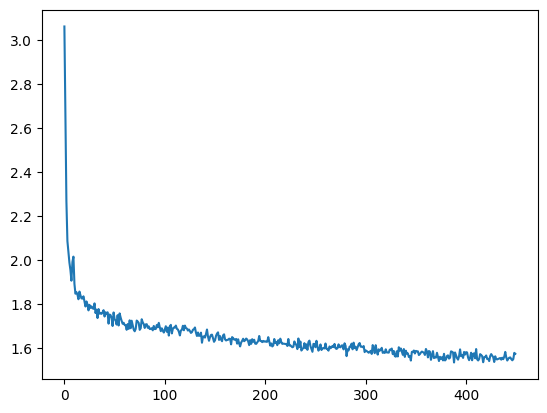

In [8]:
plt.plot(losses)

In [21]:
x = one_hots[100:110]
latent = encoder(x)
y = decoder(latent)

In [22]:
from_one_hot(x, params)

['O=C1NCCCN1',
 'C1CC[NH+]=CNC1',
 'NC1=CC=CC=N1',
 'NC1=CC=CN=C1',
 'O=C1NC=CC=N1',
 'OC1CCCC1=O',
 'OC1CCC(=O)C1',
 'O=C1COCCN1',
 'O=C1CCCNC1',
 'O1C=CC=CC=CC=C1']

In [23]:
from_one_hot(y, params)

['C1C1=2',
 'C1C1=2',
 'O1C112',
 'O1C112',
 'C1C1=2',
 'C1C1=2',
 'C1C1=2',
 'C1C1=2',
 'C1C1=2',
 'C1C1=2']